#  Training FFNN with noise


## 1 Data pre-processing.

In [65]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from Euler_approximation import euler
import scipy
from scipy import signal
from scipy.signal import lfilter


## Generate Gussian noise
sigma=0.08 #  standard deviation: Range 0.01-0.1
def G_noise(x):
    mu=0  # noise mean
    noise=np.random.normal(mu,sigma, x.shape)
    x=x+noise
    return x

[a1,a2,a3,a4]=[20,40,60,80]
[phi1_a1,phi2_a1]=euler(a1)
[phi1_a2,phi2_a2]=euler(a2)
[phi1_a3,phi2_a3]=euler(a3)
[phi1_a4,phi2_a4]=euler(a4)

split_time =8000
di=0.001


#Filter parameters
filter_window=int(1201+sigma*10000)  #Smooth filter window changes as standard deviation(sigma)
filter_poly=5

#Filte noisy angle with Savitzky–Golay
phi1_a1=signal.savgol_filter(G_noise(phi1_a1), filter_window, filter_poly)
phi1_a2=signal.savgol_filter(G_noise(phi1_a2), filter_window, filter_poly)
phi1_a3=signal.savgol_filter(G_noise(phi1_a3), filter_window, filter_poly)
phi1_a4=signal.savgol_filter(G_noise(phi1_a4), filter_window, filter_poly)
 #Get the angle sequence
phi1_all=np.concatenate((phi1_a1[:split_time],phi1_a2[:split_time],phi1_a3[:split_time],phi1_a4[:split_time]),axis=0)

#Get the angular velocity
phi2_a1[:split_time]=(phi1_a1[1:split_time+1]-phi1_a1[:split_time])/di
phi2_a2[:split_time]=(phi1_a2[1:split_time+1]-phi1_a2[:split_time])/di
phi2_a3[:split_time]=(phi1_a3[1:split_time+1]-phi1_a3[:split_time])/di
phi2_a4[:split_time]=(phi1_a4[1:split_time+1]-phi1_a4[:split_time])/di


#Filte noisy angular velocity with Savitzky–Golay
phi2_a1=signal.savgol_filter(phi2_a1,filter_window,  filter_poly)
phi2_a2=signal.savgol_filter(phi2_a2, filter_window, filter_poly)
phi2_a3=signal.savgol_filter(phi2_a3, filter_window, filter_poly)
phi2_a4=signal.savgol_filter(phi2_a4, filter_window, filter_poly)

#Get the angular velocity sequence
phi2_all=np.concatenate((phi2_a1[:split_time],phi2_a2[:split_time],phi2_a3[:split_time],phi2_a4[:split_time]),axis=0)
                        
#Filte angular acceleration with Savitzky–Golay
phi2_diff_a1=signal.savgol_filter(phi2_a1[1:split_time+1]-phi2_a1[:split_time],filter_window, filter_poly)
phi2_diff_a2=signal.savgol_filter(phi2_a2[1:split_time+1]-phi2_a2[:split_time], filter_window, filter_poly)
phi2_diff_a3=signal.savgol_filter(phi2_a3[1:split_time+1]-phi2_a3[:split_time], filter_window, filter_poly)
phi2_diff_a4=signal.savgol_filter(phi2_a4[1:split_time+1]-phi2_a4[:split_time], filter_window, filter_poly)

#Get the angular acceleration sequence
phi2_diff_all=np.concatenate((phi2_diff_a1,phi2_diff_a2,phi2_diff_a3,phi2_diff_a4),axis=0)
phi2_diff_all=phi2_diff_all/di

# Get the control input sequence 
input_a1=a1*np.ones(split_time)
input_a2=a2*np.ones(split_time)
input_a3=a3*np.ones(split_time)
input_a4=a4*np.ones(split_time)
input=np.concatenate((input_a1,input_a2,input_a3,input_a4),axis=0)

# Stack all data together
series_input=np.stack((phi1_all,phi2_all,input,phi2_diff_all),axis=1)
series_input=series_input.reshape(4*split_time,4)
series_input=tf.random.shuffle(series_input)
#Shuffle data for avioding overfitting
x_train_G=series_input[:,0:3]
y_train_G=series_input[:,3]


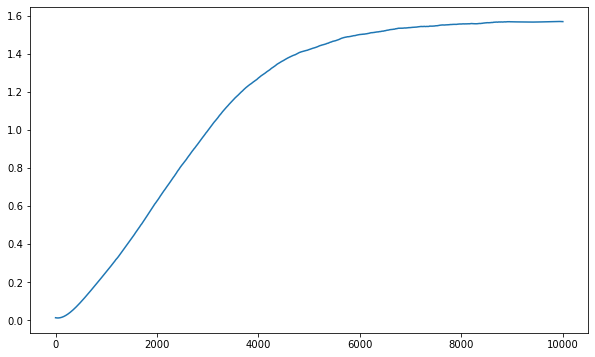

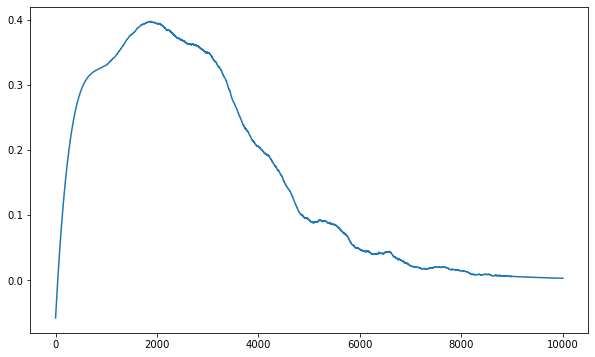

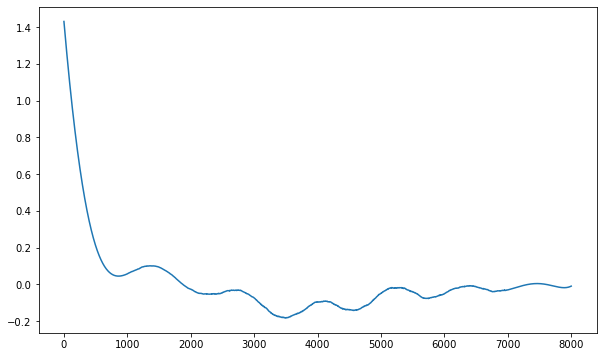

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(phi1_a1)
plt.figure(figsize=(10, 6))
plt.plot(phi2_a1)
plt.figure(figsize=(10, 6))
plt.plot(phi2_diff_all[:split_time])

## 2.Train FFNN with noisy data

In [73]:
MAE_G = np.ones((1, 10)).squeeze()
for seed in range(10):  #Try different seed and the get the best one.     
        tf.random.set_seed(5+seed*5)
        model = tf.keras.Sequential([tf.keras.layers.Dense(60,kernel_initializer='glorot_uniform',activation="elu"),
                                     tf.keras.layers.Dense(30,kernel_initializer='glorot_uniform', activation="elu"),
                                     tf.keras.layers.Dense(1)])

        optimizer = tf.keras.optimizers.SGD(lr=5e-4, momentum=0.9)

        model.compile(loss=tf.keras.losses.Huber(),
                      optimizer=optimizer,
                      metrics=["mae"])

        class CustomCallbacks(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs={}):
              if(logs.get('mae')<0.1):
                print("\n 99% acc reached")
                self.model.stop_training = True

        history= model.fit(x_train_G, y_train_G, epochs=800, callbacks=[CustomCallbacks()])
        trainPredict = model.predict(x_train_G)
        error=np.abs(trainPredict[:,0]*0.001-y_train_G*0.001)
        MAE_G[seed]=np.mean(error)  # the mean absolute error
        
        if MAE_G[seed]==np.min(MAE_G):
            model.save('FFNN_noise %f.h5'%(sigma))
            m=seed
           
        

Epoch 1/800

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1000/1000 [==============================] - 0s 281us/step - loss: 0.3542 - mae: 0.5606
Epoch 2/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.2993 - mae: 0.4843
Epoch 3/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.2955 - mae: 0.4813
Epoch 4/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.2929 - mae: 0.4754
Epoch 5/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.2891 - mae: 0.4727
Epoch 6/

1000/1000 [==============================] - 0s 288us/step - loss: 0.2028 - mae: 0.3649
Epoch 76/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.2106 - mae: 0.3763
Epoch 77/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.2009 - mae: 0.3602
Epoch 78/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1996 - mae: 0.3574
Epoch 79/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.2012 - mae: 0.3616
Epoch 80/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.2001 - mae: 0.3617
Epoch 81/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1980 - mae: 0.3539
Epoch 82/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1922 - mae: 0.3473
Epoch 83/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1983 - mae: 0.3611
Epoch 84/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1956 - mae: 0.3537
Epo

1000/1000 [==============================] - 0s 276us/step - loss: 0.1611 - mae: 0.3110
Epoch 156/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1674 - mae: 0.3191
Epoch 157/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.1666 - mae: 0.3177
Epoch 158/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1693 - mae: 0.3220
Epoch 159/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1669 - mae: 0.3189
Epoch 160/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1628 - mae: 0.3113
Epoch 161/800
1000/1000 [==============================] - 0s 275us/step - loss: 0.1654 - mae: 0.3169
Epoch 162/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1745 - mae: 0.3323
Epoch 163/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1655 - mae: 0.3174
Epoch 164/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1651 - mae: 0

1000/1000 [==============================] - 0s 283us/step - loss: 0.1698 - mae: 0.3349
Epoch 236/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1688 - mae: 0.3317
Epoch 237/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1659 - mae: 0.3244
Epoch 238/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1646 - mae: 0.3216
Epoch 239/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1651 - mae: 0.3206
Epoch 240/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1645 - mae: 0.3184
Epoch 241/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1706 - mae: 0.3330
Epoch 242/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1727 - mae: 0.3337
Epoch 243/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1719 - mae: 0.3356
Epoch 244/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1663 - mae: 0

1000/1000 [==============================] - 0s 284us/step - loss: 0.1746 - mae: 0.3416
Epoch 316/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1730 - mae: 0.3327
Epoch 317/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1699 - mae: 0.3221
Epoch 318/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1746 - mae: 0.3391
Epoch 319/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1742 - mae: 0.3370
Epoch 320/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1800 - mae: 0.3419
Epoch 321/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1759 - mae: 0.3339
Epoch 322/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1762 - mae: 0.3342
Epoch 323/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1681 - mae: 0.3357
Epoch 324/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1794 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.1403 - mae: 0.2829
Epoch 396/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1479 - mae: 0.3050
Epoch 397/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1760 - mae: 0.3675
Epoch 398/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1672 - mae: 0.3537
Epoch 399/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1662 - mae: 0.3440
Epoch 400/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1749 - mae: 0.3476
Epoch 401/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1691 - mae: 0.3419
Epoch 402/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1673 - mae: 0.3273
Epoch 403/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1648 - mae: 0.3351
Epoch 404/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1625 - mae: 0

1000/1000 [==============================] - 0s 280us/step - loss: 0.1437 - mae: 0.3036
Epoch 476/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1431 - mae: 0.3035
Epoch 477/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1430 - mae: 0.3010
Epoch 478/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1573 - mae: 0.3326
Epoch 479/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1669 - mae: 0.3324
Epoch 480/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1634 - mae: 0.3346
Epoch 481/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1709 - mae: 0.3312
Epoch 482/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1511 - mae: 0.3036
Epoch 483/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1635 - mae: 0.3394
Epoch 484/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1611 - mae: 0

1000/1000 [==============================] - 0s 283us/step - loss: 0.1525 - mae: 0.2943
Epoch 556/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1537 - mae: 0.2988
Epoch 557/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1597 - mae: 0.3132
Epoch 558/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1456 - mae: 0.2868
Epoch 559/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1591 - mae: 0.3076
Epoch 560/800
1000/1000 [==============================] - 0s 286us/step - loss: 0.1552 - mae: 0.3005
Epoch 561/800
1000/1000 [==============================] - 0s 287us/step - loss: 0.1568 - mae: 0.3018
Epoch 562/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1532 - mae: 0.3033
Epoch 563/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1521 - mae: 0.2943
Epoch 564/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1559 - mae: 0

1000/1000 [==============================] - 0s 283us/step - loss: 0.1496 - mae: 0.2824
Epoch 636/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1421 - mae: 0.2776
Epoch 637/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1536 - mae: 0.2939
Epoch 638/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1433 - mae: 0.2756
Epoch 639/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1409 - mae: 0.2722
Epoch 640/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1538 - mae: 0.2956
Epoch 641/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1457 - mae: 0.2822
Epoch 642/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1444 - mae: 0.2772
Epoch 643/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1429 - mae: 0.2744
Epoch 644/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1429 - mae: 0

1000/1000 [==============================] - 0s 278us/step - loss: 0.1496 - mae: 0.3038
Epoch 716/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1450 - mae: 0.2902
Epoch 717/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1364 - mae: 0.2784
Epoch 718/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1399 - mae: 0.2820
Epoch 719/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1378 - mae: 0.2812
Epoch 720/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1378 - mae: 0.2782
Epoch 721/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1376 - mae: 0.2808
Epoch 722/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.1408 - mae: 0.2855
Epoch 723/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1454 - mae: 0.2841
Epoch 724/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1452 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.1415 - mae: 0.2771
Epoch 796/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1428 - mae: 0.2747
Epoch 797/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1387 - mae: 0.2795
Epoch 798/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1349 - mae: 0.2686
Epoch 799/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1354 - mae: 0.2724
Epoch 800/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1433 - mae: 0.2767
Epoch 1/800

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author

1000/1000 [==============================] - 0s 283us/step - loss: 0.2412 - mae: 0.4216
Epoch 70/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.2265 - mae: 0.4038
Epoch 71/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.2200 - mae: 0.3858
Epoch 72/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.2276 - mae: 0.3937
Epoch 73/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.2090 - mae: 0.3685
Epoch 74/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.2170 - mae: 0.3783
Epoch 75/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.2083 - mae: 0.3628
Epoch 76/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.2089 - mae: 0.3671
Epoch 77/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1995 - mae: 0.3515
Epoch 78/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.2515 - mae: 0.4134
Epo

1000/1000 [==============================] - 0s 279us/step - loss: 0.1797 - mae: 0.3292
Epoch 150/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1800 - mae: 0.3311
Epoch 151/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1735 - mae: 0.3205
Epoch 152/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1696 - mae: 0.3144
Epoch 153/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1733 - mae: 0.3218
Epoch 154/800
1000/1000 [==============================] - 0s 287us/step - loss: 0.1734 - mae: 0.3225
Epoch 155/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1703 - mae: 0.3152
Epoch 156/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1704 - mae: 0.3169
Epoch 157/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1704 - mae: 0.3165
Epoch 158/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1706 - mae: 0

1000/1000 [==============================] - 0s 280us/step - loss: 0.1569 - mae: 0.2911
Epoch 230/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1632 - mae: 0.3087
Epoch 231/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1603 - mae: 0.2995
Epoch 232/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1589 - mae: 0.2947
Epoch 233/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1623 - mae: 0.3072
Epoch 234/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1602 - mae: 0.3002
Epoch 235/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1579 - mae: 0.2922
Epoch 236/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1593 - mae: 0.2999
Epoch 237/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1555 - mae: 0.2899
Epoch 238/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1627 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.1509 - mae: 0.2886
Epoch 310/800
1000/1000 [==============================] - 0s 288us/step - loss: 0.1539 - mae: 0.2968
Epoch 311/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1504 - mae: 0.2893
Epoch 312/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1484 - mae: 0.2827
Epoch 313/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1482 - mae: 0.2849
Epoch 314/800
1000/1000 [==============================] - 0s 289us/step - loss: 0.1563 - mae: 0.2988
Epoch 315/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1582 - mae: 0.3011
Epoch 316/800
1000/1000 [==============================] - 0s 287us/step - loss: 0.1489 - mae: 0.2866
Epoch 317/800
1000/1000 [==============================] - 0s 302us/step - loss: 0.1479 - mae: 0.2847
Epoch 318/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1521 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.1747 - mae: 0.3138
Epoch 390/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1748 - mae: 0.3207
Epoch 391/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1606 - mae: 0.2940
Epoch 392/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1707 - mae: 0.3079
Epoch 393/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1642 - mae: 0.2990
Epoch 394/800
1000/1000 [==============================] - 0s 286us/step - loss: 0.1739 - mae: 0.3133
Epoch 395/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1667 - mae: 0.2997
Epoch 396/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1593 - mae: 0.2924
Epoch 397/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1795 - mae: 0.3218
Epoch 398/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1589 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.1627 - mae: 0.2924
Epoch 470/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1761 - mae: 0.3054
Epoch 471/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1582 - mae: 0.2847
Epoch 472/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1694 - mae: 0.3001
Epoch 473/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1564 - mae: 0.2852
Epoch 474/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1626 - mae: 0.2903
Epoch 475/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1664 - mae: 0.2968
Epoch 476/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1672 - mae: 0.2989
Epoch 477/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1656 - mae: 0.2942
Epoch 478/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1621 - mae: 0

1000/1000 [==============================] - 0s 283us/step - loss: 0.1903 - mae: 0.3484
Epoch 550/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1730 - mae: 0.3302
Epoch 551/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1697 - mae: 0.3290
Epoch 552/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1634 - mae: 0.3195
Epoch 553/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1574 - mae: 0.3092
Epoch 554/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1546 - mae: 0.3082
Epoch 555/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1485 - mae: 0.2907
Epoch 556/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1510 - mae: 0.3004
Epoch 557/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1505 - mae: 0.3006
Epoch 558/800
1000/1000 [==============================] - 0s 290us/step - loss: 0.1452 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.1478 - mae: 0.2696
Epoch 630/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1552 - mae: 0.2814
Epoch 631/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1568 - mae: 0.2798
Epoch 632/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1544 - mae: 0.2784
Epoch 633/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1673 - mae: 0.2991
Epoch 634/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1996 - mae: 0.3467
Epoch 635/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1732 - mae: 0.3083
Epoch 636/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1703 - mae: 0.3039
Epoch 637/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1647 - mae: 0.2935
Epoch 638/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1631 - mae: 0

1000/1000 [==============================] - 0s 280us/step - loss: 0.1375 - mae: 0.2628
Epoch 710/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1361 - mae: 0.2622
Epoch 711/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1411 - mae: 0.2701
Epoch 712/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.1376 - mae: 0.2633
Epoch 713/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1372 - mae: 0.2636
Epoch 714/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1364 - mae: 0.2618
Epoch 715/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1390 - mae: 0.2672
Epoch 716/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1411 - mae: 0.2724
Epoch 717/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1408 - mae: 0.2715
Epoch 718/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1347 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.1452 - mae: 0.2773
Epoch 790/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1406 - mae: 0.2690
Epoch 791/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1440 - mae: 0.2748
Epoch 792/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1431 - mae: 0.2701
Epoch 793/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1422 - mae: 0.2723
Epoch 794/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1426 - mae: 0.2739
Epoch 795/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1369 - mae: 0.2651
Epoch 796/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1417 - mae: 0.2708
Epoch 797/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1431 - mae: 0.2714
Epoch 798/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1558 - mae: 0

1000/1000 [==============================] - 0s 284us/step - loss: 0.2143 - mae: 0.3884
Epoch 64/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.2139 - mae: 0.3861
Epoch 65/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.2194 - mae: 0.3919
Epoch 66/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.2151 - mae: 0.3893
Epoch 67/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.2286 - mae: 0.4085
Epoch 68/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.2126 - mae: 0.3861
Epoch 69/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.2051 - mae: 0.3726
Epoch 70/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.2139 - mae: 0.3872
Epoch 71/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.2047 - mae: 0.3706
Epoch 72/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.2046 - mae: 0.3743
Epo

1000/1000 [==============================] - 0s 280us/step - loss: 0.1635 - mae: 0.3131
Epoch 144/800
1000/1000 [==============================] - 0s 286us/step - loss: 0.1571 - mae: 0.2992
Epoch 145/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1669 - mae: 0.3196
Epoch 146/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1588 - mae: 0.3034
Epoch 147/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1633 - mae: 0.3138
Epoch 148/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1633 - mae: 0.3133
Epoch 149/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1589 - mae: 0.3023
Epoch 150/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1566 - mae: 0.3008
Epoch 151/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1575 - mae: 0.3031
Epoch 152/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1621 - mae: 0

1000/1000 [==============================] - 0s 282us/step - loss: 0.1635 - mae: 0.3187
Epoch 224/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1688 - mae: 0.3189
Epoch 225/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1614 - mae: 0.3154
Epoch 226/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1619 - mae: 0.3134
Epoch 227/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1625 - mae: 0.3128
Epoch 228/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1642 - mae: 0.3189
Epoch 229/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1595 - mae: 0.3087
Epoch 230/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1679 - mae: 0.3282
Epoch 231/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1627 - mae: 0.3170
Epoch 232/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1613 - mae: 0

1000/1000 [==============================] - 0s 282us/step - loss: 0.1533 - mae: 0.3006
Epoch 304/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1633 - mae: 0.3251
Epoch 305/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1700 - mae: 0.3314
Epoch 306/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.1693 - mae: 0.3377
Epoch 307/800
1000/1000 [==============================] - 0s 287us/step - loss: 0.1693 - mae: 0.3317
Epoch 308/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1680 - mae: 0.3327
Epoch 309/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1603 - mae: 0.3166
Epoch 310/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1663 - mae: 0.3348
Epoch 311/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1717 - mae: 0.3470
Epoch 312/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1613 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.1614 - mae: 0.3213
Epoch 384/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1628 - mae: 0.3235
Epoch 385/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1574 - mae: 0.3108
Epoch 386/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1649 - mae: 0.3262
Epoch 387/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1613 - mae: 0.3162
Epoch 388/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1870 - mae: 0.3490
Epoch 389/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1767 - mae: 0.3306
Epoch 390/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1574 - mae: 0.3062
Epoch 391/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1480 - mae: 0.2843
Epoch 392/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1515 - mae: 0

1000/1000 [==============================] - 0s 278us/step - loss: 0.1548 - mae: 0.2985
Epoch 464/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1651 - mae: 0.3111
Epoch 465/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1651 - mae: 0.3103
Epoch 466/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1625 - mae: 0.3026
Epoch 467/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1595 - mae: 0.3037
Epoch 468/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1543 - mae: 0.2943
Epoch 469/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1640 - mae: 0.3096
Epoch 470/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1500 - mae: 0.2853
Epoch 471/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1590 - mae: 0.3032
Epoch 472/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1642 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.1488 - mae: 0.2848
Epoch 544/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1453 - mae: 0.2792
Epoch 545/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1426 - mae: 0.2712
Epoch 546/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1410 - mae: 0.2693
Epoch 547/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1395 - mae: 0.2679
Epoch 548/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1384 - mae: 0.2670
Epoch 549/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1374 - mae: 0.2633
Epoch 550/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1378 - mae: 0.2660
Epoch 551/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1419 - mae: 0.2876
Epoch 552/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1485 - mae: 0

1000/1000 [==============================] - 0s 282us/step - loss: 0.1504 - mae: 0.2791
Epoch 624/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.1569 - mae: 0.2878
Epoch 625/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1508 - mae: 0.2778
Epoch 626/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1495 - mae: 0.2767
Epoch 627/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1562 - mae: 0.2876
Epoch 628/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.1519 - mae: 0.2794
Epoch 629/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1494 - mae: 0.2779
Epoch 630/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1553 - mae: 0.2806
Epoch 631/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1456 - mae: 0.2696
Epoch 632/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1438 - mae: 0

1000/1000 [==============================] - 0s 280us/step - loss: 0.1451 - mae: 0.2665
Epoch 704/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1509 - mae: 0.2728
Epoch 705/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1503 - mae: 0.2756
Epoch 706/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1494 - mae: 0.2737
Epoch 707/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1414 - mae: 0.2590
Epoch 708/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1433 - mae: 0.2638
Epoch 709/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1471 - mae: 0.2672
Epoch 710/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1506 - mae: 0.2733
Epoch 711/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1397 - mae: 0.2574
Epoch 712/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1461 - mae: 0

1000/1000 [==============================] - 0s 278us/step - loss: 0.1374 - mae: 0.2541
Epoch 784/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1484 - mae: 0.2665
Epoch 785/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1390 - mae: 0.2575
Epoch 786/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1367 - mae: 0.2519
Epoch 787/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1437 - mae: 0.2613
Epoch 788/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1403 - mae: 0.2599
Epoch 789/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1444 - mae: 0.2634
Epoch 790/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1384 - mae: 0.2518
Epoch 791/800
1000/1000 [==============================] - 0s 274us/step - loss: 0.1411 - mae: 0.2590
Epoch 792/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.1331 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.2633 - mae: 0.4513
Epoch 58/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.2354 - mae: 0.4173
Epoch 59/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.2283 - mae: 0.4031
Epoch 60/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.2486 - mae: 0.4203
Epoch 61/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.2638 - mae: 0.4423
Epoch 62/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.2597 - mae: 0.4372
Epoch 63/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.2557 - mae: 0.4277
Epoch 64/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.2523 - mae: 0.4248
Epoch 65/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.2457 - mae: 0.4121
Epoch 66/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.2484 - mae: 0.4213
Epo

1000/1000 [==============================] - 0s 280us/step - loss: 0.1782 - mae: 0.3331
Epoch 138/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1784 - mae: 0.3295
Epoch 139/800
1000/1000 [==============================] - 0s 287us/step - loss: 0.1829 - mae: 0.3405
Epoch 140/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1812 - mae: 0.3339
Epoch 141/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1792 - mae: 0.3316
Epoch 142/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1802 - mae: 0.3320
Epoch 143/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1784 - mae: 0.3320
Epoch 144/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1749 - mae: 0.3224
Epoch 145/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1757 - mae: 0.3255
Epoch 146/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1786 - mae: 0

1000/1000 [==============================] - 0s 277us/step - loss: 0.1589 - mae: 0.2954
Epoch 218/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1588 - mae: 0.2927
Epoch 219/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1587 - mae: 0.2954
Epoch 220/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1530 - mae: 0.2797
Epoch 221/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1565 - mae: 0.2892
Epoch 222/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1551 - mae: 0.2868
Epoch 223/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.1556 - mae: 0.2894
Epoch 224/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1549 - mae: 0.2865
Epoch 225/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1598 - mae: 0.2966
Epoch 226/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1546 - mae: 0

1000/1000 [==============================] - 0s 294us/step - loss: 0.1497 - mae: 0.2807
Epoch 298/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1485 - mae: 0.2797
Epoch 299/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1468 - mae: 0.2750
Epoch 300/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1502 - mae: 0.2829
Epoch 301/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1504 - mae: 0.2861
Epoch 302/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1490 - mae: 0.2807
Epoch 303/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1472 - mae: 0.2786
Epoch 304/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1448 - mae: 0.2693
Epoch 305/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1493 - mae: 0.2825
Epoch 306/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1493 - mae: 0

1000/1000 [==============================] - 0s 279us/step - loss: 0.1516 - mae: 0.2998
Epoch 378/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1519 - mae: 0.2974
Epoch 379/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1537 - mae: 0.3062
Epoch 380/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1515 - mae: 0.3011
Epoch 381/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1536 - mae: 0.3055
Epoch 382/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1451 - mae: 0.2851
Epoch 383/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1497 - mae: 0.2963
Epoch 384/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1492 - mae: 0.2952
Epoch 385/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1474 - mae: 0.2903
Epoch 386/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1526 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.1613 - mae: 0.3161
Epoch 458/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1595 - mae: 0.3078
Epoch 459/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1623 - mae: 0.3095
Epoch 460/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1638 - mae: 0.3175
Epoch 461/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1648 - mae: 0.3125
Epoch 462/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1783 - mae: 0.3334
Epoch 463/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1555 - mae: 0.3034
Epoch 464/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1542 - mae: 0.3097
Epoch 465/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1531 - mae: 0.3029
Epoch 466/800
1000/1000 [==============================] - 0s 290us/step - loss: 0.1522 - mae: 0

1000/1000 [==============================] - 0s 279us/step - loss: 0.1456 - mae: 0.2917
Epoch 538/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1408 - mae: 0.2829
Epoch 539/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1464 - mae: 0.2902
Epoch 540/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1453 - mae: 0.2914
Epoch 541/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1517 - mae: 0.3024
Epoch 542/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1477 - mae: 0.2960
Epoch 543/800
1000/1000 [==============================] - 0s 275us/step - loss: 0.1592 - mae: 0.3170
Epoch 544/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1686 - mae: 0.3239
Epoch 545/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1684 - mae: 0.3344
Epoch 546/800
1000/1000 [==============================] - 0s 274us/step - loss: 0.1678 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.1647 - mae: 0.2998
Epoch 618/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1571 - mae: 0.2851
Epoch 619/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1555 - mae: 0.2840
Epoch 620/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1586 - mae: 0.2922
Epoch 621/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1502 - mae: 0.2767
Epoch 622/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1566 - mae: 0.2864
Epoch 623/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1629 - mae: 0.2998
Epoch 624/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1662 - mae: 0.2969
Epoch 625/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1530 - mae: 0.2829
Epoch 626/800
1000/1000 [==============================] - 0s 275us/step - loss: 0.1624 - mae: 0

1000/1000 [==============================] - 0s 275us/step - loss: 0.1638 - mae: 0.2929
Epoch 698/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1615 - mae: 0.2911
Epoch 699/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1539 - mae: 0.2805
Epoch 700/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1399 - mae: 0.2596
Epoch 701/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1565 - mae: 0.2825
Epoch 702/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1540 - mae: 0.2791
Epoch 703/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1568 - mae: 0.2798
Epoch 704/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1526 - mae: 0.2764
Epoch 705/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1518 - mae: 0.2731
Epoch 706/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1511 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.1461 - mae: 0.2535
Epoch 778/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1480 - mae: 0.2596
Epoch 779/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1470 - mae: 0.2596
Epoch 780/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1439 - mae: 0.2516
Epoch 781/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1420 - mae: 0.2533
Epoch 782/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1425 - mae: 0.2545
Epoch 783/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1417 - mae: 0.2561
Epoch 784/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1419 - mae: 0.2585
Epoch 785/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1398 - mae: 0.2548
Epoch 786/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1403 - mae: 0

1000/1000 [==============================] - 0s 279us/step - loss: 0.2398 - mae: 0.4262
Epoch 52/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.2304 - mae: 0.4076
Epoch 53/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.2374 - mae: 0.4139
Epoch 54/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.2306 - mae: 0.4015
Epoch 55/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.2266 - mae: 0.3985
Epoch 56/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.2316 - mae: 0.4055
Epoch 57/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.2482 - mae: 0.4187
Epoch 58/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.2173 - mae: 0.3878
Epoch 59/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.2181 - mae: 0.3859
Epoch 60/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.2151 - mae: 0.3792
Epo

1000/1000 [==============================] - 0s 281us/step - loss: 0.1683 - mae: 0.3135
Epoch 132/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1753 - mae: 0.3288
Epoch 133/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1716 - mae: 0.3197
Epoch 134/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1601 - mae: 0.2960
Epoch 135/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1659 - mae: 0.3098
Epoch 136/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1702 - mae: 0.3181
Epoch 137/800
1000/1000 [==============================] - 0s 286us/step - loss: 0.1662 - mae: 0.3077
Epoch 138/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1682 - mae: 0.3134
Epoch 139/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1740 - mae: 0.3241
Epoch 140/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1685 - mae: 0

1000/1000 [==============================] - 0s 282us/step - loss: 0.1689 - mae: 0.3118
Epoch 212/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1649 - mae: 0.3107
Epoch 213/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1627 - mae: 0.3025
Epoch 214/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1635 - mae: 0.3031
Epoch 215/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1592 - mae: 0.2967
Epoch 216/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1672 - mae: 0.3088
Epoch 217/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1632 - mae: 0.3051
Epoch 218/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1637 - mae: 0.3041
Epoch 219/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1667 - mae: 0.3084
Epoch 220/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1633 - mae: 0

1000/1000 [==============================] - 0s 283us/step - loss: 0.1977 - mae: 0.3533
Epoch 292/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1770 - mae: 0.3326
Epoch 293/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1551 - mae: 0.2911
Epoch 294/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.1503 - mae: 0.2871
Epoch 295/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1739 - mae: 0.3248
Epoch 296/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1739 - mae: 0.3201
Epoch 297/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.1694 - mae: 0.3121
Epoch 298/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1582 - mae: 0.2998
Epoch 299/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1623 - mae: 0.3049
Epoch 300/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1862 - mae: 0

1000/1000 [==============================] - 0s 279us/step - loss: 0.1954 - mae: 0.3470
Epoch 372/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1479 - mae: 0.2847
Epoch 373/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1639 - mae: 0.3081
Epoch 374/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1642 - mae: 0.3074
Epoch 375/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1711 - mae: 0.3146
Epoch 376/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1623 - mae: 0.2986
Epoch 377/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1552 - mae: 0.2858
Epoch 378/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1656 - mae: 0.2985
Epoch 379/800
1000/1000 [==============================] - 0s 286us/step - loss: 0.1614 - mae: 0.2919
Epoch 380/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1587 - mae: 0

1000/1000 [==============================] - 0s 284us/step - loss: 0.1538 - mae: 0.2767
Epoch 452/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1542 - mae: 0.2771
Epoch 453/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1549 - mae: 0.2793
Epoch 454/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1635 - mae: 0.2938
Epoch 455/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1604 - mae: 0.2830
Epoch 456/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1548 - mae: 0.2798
Epoch 457/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1566 - mae: 0.2810
Epoch 458/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1593 - mae: 0.2844
Epoch 459/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.1556 - mae: 0.2792
Epoch 460/800
1000/1000 [==============================] - 0s 289us/step - loss: 0.1542 - mae: 0

1000/1000 [==============================] - 0s 291us/step - loss: 0.1489 - mae: 0.2704
Epoch 532/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1491 - mae: 0.2685
Epoch 533/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1607 - mae: 0.2862
Epoch 534/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1506 - mae: 0.2709
Epoch 535/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1521 - mae: 0.2755
Epoch 536/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1511 - mae: 0.2715
Epoch 537/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1496 - mae: 0.2680
Epoch 538/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1396 - mae: 0.2574
Epoch 539/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1425 - mae: 0.2625
Epoch 540/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1506 - mae: 0

1000/1000 [==============================] - 0s 282us/step - loss: 0.1457 - mae: 0.2632
Epoch 612/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1452 - mae: 0.2638
Epoch 613/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1507 - mae: 0.2712
Epoch 614/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1336 - mae: 0.2489
Epoch 615/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1345 - mae: 0.2498
Epoch 616/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1398 - mae: 0.2561
Epoch 617/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1470 - mae: 0.2638
Epoch 618/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1480 - mae: 0.2672
Epoch 619/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1451 - mae: 0.2623
Epoch 620/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1494 - mae: 0

1000/1000 [==============================] - 0s 280us/step - loss: 0.1389 - mae: 0.2386
Epoch 692/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1405 - mae: 0.2483
Epoch 693/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1480 - mae: 0.2825
Epoch 694/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1479 - mae: 0.2729
Epoch 695/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1441 - mae: 0.2637
Epoch 696/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1351 - mae: 0.2512
Epoch 697/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1463 - mae: 0.2657
Epoch 698/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1364 - mae: 0.2521
Epoch 699/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1325 - mae: 0.2472
Epoch 700/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1334 - mae: 0

1000/1000 [==============================] - 0s 280us/step - loss: 0.1330 - mae: 0.2439
Epoch 772/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1250 - mae: 0.2366
Epoch 773/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1432 - mae: 0.2544
Epoch 774/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1463 - mae: 0.2462
Epoch 775/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1348 - mae: 0.2436
Epoch 776/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1329 - mae: 0.2470
Epoch 777/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1306 - mae: 0.2425
Epoch 778/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1325 - mae: 0.2438
Epoch 779/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1373 - mae: 0.2518
Epoch 780/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1254 - mae: 0

Epoch 45/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.2299 - mae: 0.4058
Epoch 46/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.2495 - mae: 0.4337
Epoch 47/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.2442 - mae: 0.4208
Epoch 48/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.2387 - mae: 0.4139
Epoch 49/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.2717 - mae: 0.4414
Epoch 50/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.2426 - mae: 0.4181
Epoch 51/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.2405 - mae: 0.4132
Epoch 52/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.2488 - mae: 0.4264
Epoch 53/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.2301 - mae: 0.4069
Epoch 54/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.2376 - ma

1000/1000 [==============================] - 0s 280us/step - loss: 0.1816 - mae: 0.3278
Epoch 126/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1819 - mae: 0.3284
Epoch 127/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1773 - mae: 0.3211
Epoch 128/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1923 - mae: 0.3449
Epoch 129/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1760 - mae: 0.3189
Epoch 130/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1826 - mae: 0.3299
Epoch 131/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1853 - mae: 0.3310
Epoch 132/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1770 - mae: 0.3200
Epoch 133/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1802 - mae: 0.3251
Epoch 134/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1819 - mae: 0

1000/1000 [==============================] - 0s 284us/step - loss: 0.1582 - mae: 0.2891
Epoch 206/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1531 - mae: 0.2776
Epoch 207/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1575 - mae: 0.2879
Epoch 208/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1550 - mae: 0.2836
Epoch 209/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1549 - mae: 0.2822
Epoch 210/800
1000/1000 [==============================] - 0s 287us/step - loss: 0.1615 - mae: 0.2939
Epoch 211/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1518 - mae: 0.2750
Epoch 212/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1555 - mae: 0.2837
Epoch 213/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1517 - mae: 0.2744
Epoch 214/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1540 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.1467 - mae: 0.2689
Epoch 286/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1478 - mae: 0.2715
Epoch 287/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1492 - mae: 0.2737
Epoch 288/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1476 - mae: 0.2707
Epoch 289/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1481 - mae: 0.2717
Epoch 290/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1478 - mae: 0.2728
Epoch 291/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1500 - mae: 0.2761
Epoch 292/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1471 - mae: 0.2691
Epoch 293/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1479 - mae: 0.2721
Epoch 294/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1489 - mae: 0

1000/1000 [==============================] - 0s 278us/step - loss: 0.1453 - mae: 0.2697
Epoch 366/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1458 - mae: 0.2696
Epoch 367/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1536 - mae: 0.2864
Epoch 368/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1476 - mae: 0.2737
Epoch 369/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1525 - mae: 0.2842
Epoch 370/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1485 - mae: 0.2751
Epoch 371/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1517 - mae: 0.2820
Epoch 372/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1468 - mae: 0.2700
Epoch 373/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1488 - mae: 0.2767
Epoch 374/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1477 - mae: 0

1000/1000 [==============================] - 0s 282us/step - loss: 0.1514 - mae: 0.2752
Epoch 446/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1493 - mae: 0.2717
Epoch 447/800
1000/1000 [==============================] - 0s 287us/step - loss: 0.1599 - mae: 0.2887
Epoch 448/800
1000/1000 [==============================] - 0s 289us/step - loss: 0.1585 - mae: 0.2850
Epoch 449/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.1520 - mae: 0.2728
Epoch 450/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1520 - mae: 0.2743
Epoch 451/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1576 - mae: 0.2830
Epoch 452/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1776 - mae: 0.3127
Epoch 453/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1489 - mae: 0.2652
Epoch 454/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1473 - mae: 0

1000/1000 [==============================] - 0s 282us/step - loss: 0.1592 - mae: 0.2834
Epoch 526/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1579 - mae: 0.2825
Epoch 527/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1490 - mae: 0.2684
Epoch 528/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1557 - mae: 0.2795
Epoch 529/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1608 - mae: 0.2856
Epoch 530/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1523 - mae: 0.2701
Epoch 531/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1541 - mae: 0.2782
Epoch 532/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1573 - mae: 0.2804
Epoch 533/800
1000/1000 [==============================] - 0s 290us/step - loss: 0.1517 - mae: 0.2711
Epoch 534/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1518 - mae: 0

1000/1000 [==============================] - 0s 282us/step - loss: 0.1480 - mae: 0.2625
Epoch 606/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1411 - mae: 0.2553
Epoch 607/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1421 - mae: 0.2621
Epoch 608/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1547 - mae: 0.2955
Epoch 609/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.1428 - mae: 0.2694
Epoch 610/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1484 - mae: 0.2763
Epoch 611/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1545 - mae: 0.2845
Epoch 612/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1480 - mae: 0.2795
Epoch 613/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1528 - mae: 0.2819
Epoch 614/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1515 - mae: 0

1000/1000 [==============================] - 0s 280us/step - loss: 0.1603 - mae: 0.2892
Epoch 686/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.1465 - mae: 0.2718
Epoch 687/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1393 - mae: 0.2598
Epoch 688/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1472 - mae: 0.2730
Epoch 689/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1559 - mae: 0.2825
Epoch 690/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1431 - mae: 0.2648
Epoch 691/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1548 - mae: 0.2789
Epoch 692/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1525 - mae: 0.2792
Epoch 693/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1469 - mae: 0.2695
Epoch 694/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1469 - mae: 0

1000/1000 [==============================] - 0s 279us/step - loss: 0.1343 - mae: 0.2499
Epoch 766/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.1376 - mae: 0.2559
Epoch 767/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1390 - mae: 0.2548
Epoch 768/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1449 - mae: 0.2628
Epoch 769/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1436 - mae: 0.2617
Epoch 770/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1404 - mae: 0.2540
Epoch 771/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1450 - mae: 0.2628
Epoch 772/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1371 - mae: 0.2515
Epoch 773/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1480 - mae: 0.2642
Epoch 774/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1469 - mae: 0

1000/1000 [==============================] - 0s 282us/step - loss: 0.2358 - mae: 0.4290
Epoch 39/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.2329 - mae: 0.4225
Epoch 40/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.2255 - mae: 0.4081
Epoch 41/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.2263 - mae: 0.4100
Epoch 42/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.2238 - mae: 0.4073
Epoch 43/800
1000/1000 [==============================] - 0s 290us/step - loss: 0.2294 - mae: 0.4118
Epoch 44/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.2314 - mae: 0.4170
Epoch 45/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.2355 - mae: 0.4203
Epoch 46/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.2257 - mae: 0.4036
Epoch 47/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.2392 - mae: 0.4207
Epo

1000/1000 [==============================] - 0s 283us/step - loss: 0.1770 - mae: 0.3264
Epoch 120/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1732 - mae: 0.3157
Epoch 121/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1661 - mae: 0.3084
Epoch 122/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1717 - mae: 0.3170
Epoch 123/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1681 - mae: 0.3118
Epoch 124/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1787 - mae: 0.3303
Epoch 125/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.2098 - mae: 0.3825
Epoch 126/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1712 - mae: 0.3250
Epoch 127/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1714 - mae: 0.3206
Epoch 128/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1734 - mae: 0

1000/1000 [==============================] - 0s 282us/step - loss: 0.1585 - mae: 0.3038
Epoch 200/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1623 - mae: 0.3085
Epoch 201/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1588 - mae: 0.3052
Epoch 202/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1602 - mae: 0.3111
Epoch 203/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1628 - mae: 0.3193
Epoch 204/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1608 - mae: 0.3073
Epoch 205/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1598 - mae: 0.3114
Epoch 206/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1587 - mae: 0.3057
Epoch 207/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1660 - mae: 0.3199
Epoch 208/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1621 - mae: 0

1000/1000 [==============================] - 0s 279us/step - loss: 0.1651 - mae: 0.3193
Epoch 280/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1633 - mae: 0.3213
Epoch 281/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1602 - mae: 0.3044
Epoch 282/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1629 - mae: 0.3195
Epoch 283/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1625 - mae: 0.3131
Epoch 284/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1703 - mae: 0.3218
Epoch 285/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1668 - mae: 0.3161
Epoch 286/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1701 - mae: 0.3163
Epoch 287/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1610 - mae: 0.3116
Epoch 288/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1560 - mae: 0

1000/1000 [==============================] - 0s 280us/step - loss: 0.1663 - mae: 0.3088
Epoch 360/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1571 - mae: 0.2949
Epoch 361/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1624 - mae: 0.2992
Epoch 362/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1684 - mae: 0.3110
Epoch 363/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1688 - mae: 0.3040
Epoch 364/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1498 - mae: 0.2808
Epoch 365/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1598 - mae: 0.3061
Epoch 366/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1607 - mae: 0.2940
Epoch 367/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1611 - mae: 0.2988
Epoch 368/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1604 - mae: 0

1000/1000 [==============================] - 0s 283us/step - loss: 0.1606 - mae: 0.3119
Epoch 440/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1539 - mae: 0.2913
Epoch 441/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1562 - mae: 0.3027
Epoch 442/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1519 - mae: 0.2911
Epoch 443/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1485 - mae: 0.2885
Epoch 444/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1482 - mae: 0.2925
Epoch 445/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1475 - mae: 0.2931
Epoch 446/800
1000/1000 [==============================] - 0s 289us/step - loss: 0.1475 - mae: 0.2949
Epoch 447/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1453 - mae: 0.2896
Epoch 448/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1445 - mae: 0

1000/1000 [==============================] - 0s 282us/step - loss: 0.1894 - mae: 0.3365
Epoch 520/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1500 - mae: 0.2876
Epoch 521/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1525 - mae: 0.2889
Epoch 522/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1553 - mae: 0.2960
Epoch 523/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1584 - mae: 0.2942
Epoch 524/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1530 - mae: 0.2893
Epoch 525/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1476 - mae: 0.2781
Epoch 526/800
1000/1000 [==============================] - 0s 289us/step - loss: 0.1599 - mae: 0.2981
Epoch 527/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1524 - mae: 0.2871
Epoch 528/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1585 - mae: 0

1000/1000 [==============================] - 0s 282us/step - loss: 0.1462 - mae: 0.2657
Epoch 600/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1526 - mae: 0.2802
Epoch 601/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1494 - mae: 0.2763
Epoch 602/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1462 - mae: 0.2693
Epoch 603/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1556 - mae: 0.2829
Epoch 604/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1574 - mae: 0.2829
Epoch 605/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1446 - mae: 0.2659
Epoch 606/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.1460 - mae: 0.2666
Epoch 607/800
1000/1000 [==============================] - 0s 290us/step - loss: 0.1515 - mae: 0.2712
Epoch 608/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1553 - mae: 0

1000/1000 [==============================] - 0s 283us/step - loss: 0.1474 - mae: 0.2658
Epoch 680/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1458 - mae: 0.2599
Epoch 681/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1492 - mae: 0.2698
Epoch 682/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1425 - mae: 0.2611
Epoch 683/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1464 - mae: 0.2643
Epoch 684/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1398 - mae: 0.2543
Epoch 685/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1371 - mae: 0.2532
Epoch 686/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1431 - mae: 0.2574
Epoch 687/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1500 - mae: 0.2680
Epoch 688/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1442 - mae: 0

1000/1000 [==============================] - 0s 284us/step - loss: 0.1380 - mae: 0.2536
Epoch 760/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1446 - mae: 0.2631
Epoch 761/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1432 - mae: 0.2603
Epoch 762/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1457 - mae: 0.2621
Epoch 763/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1420 - mae: 0.2527
Epoch 764/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1377 - mae: 0.2552
Epoch 765/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1427 - mae: 0.2561
Epoch 766/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1385 - mae: 0.2540
Epoch 767/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1429 - mae: 0.2592
Epoch 768/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1452 - mae: 0

1000/1000 [==============================] - 0s 279us/step - loss: 0.2507 - mae: 0.4368
Epoch 33/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.2444 - mae: 0.4277
Epoch 34/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.2497 - mae: 0.4366
Epoch 35/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.2439 - mae: 0.4289
Epoch 36/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.2488 - mae: 0.4385
Epoch 37/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.2375 - mae: 0.4178
Epoch 38/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.2491 - mae: 0.4380
Epoch 39/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.2516 - mae: 0.4379
Epoch 40/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.2361 - mae: 0.4143
Epoch 41/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.2325 - mae: 0.4136
Epo

1000/1000 [==============================] - 0s 277us/step - loss: 0.1775 - mae: 0.3241
Epoch 114/800
1000/1000 [==============================] - 0s 275us/step - loss: 0.1778 - mae: 0.3239
Epoch 115/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1916 - mae: 0.3433
Epoch 116/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1773 - mae: 0.3233
Epoch 117/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1855 - mae: 0.3365
Epoch 118/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1819 - mae: 0.3290
Epoch 119/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1793 - mae: 0.3240
Epoch 120/800
1000/1000 [==============================] - 0s 273us/step - loss: 0.1758 - mae: 0.3205
Epoch 121/800
1000/1000 [==============================] - 0s 275us/step - loss: 0.1743 - mae: 0.3184
Epoch 122/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1852 - mae: 0

1000/1000 [==============================] - 0s 280us/step - loss: 0.1652 - mae: 0.3056
Epoch 194/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1594 - mae: 0.2910
Epoch 195/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1652 - mae: 0.3037
Epoch 196/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1619 - mae: 0.2967
Epoch 197/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1636 - mae: 0.3015
Epoch 198/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1665 - mae: 0.3086
Epoch 199/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1603 - mae: 0.2922
Epoch 200/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.1575 - mae: 0.2906
Epoch 201/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1643 - mae: 0.3019
Epoch 202/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1623 - mae: 0

1000/1000 [==============================] - 0s 278us/step - loss: 0.1593 - mae: 0.3047
Epoch 274/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1525 - mae: 0.2936
Epoch 275/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1537 - mae: 0.2968
Epoch 276/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1610 - mae: 0.3069
Epoch 277/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1531 - mae: 0.2941
Epoch 278/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1597 - mae: 0.3025
Epoch 279/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1579 - mae: 0.2999
Epoch 280/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1569 - mae: 0.2996
Epoch 281/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1582 - mae: 0.2996
Epoch 282/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1555 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.1670 - mae: 0.3186
Epoch 354/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1671 - mae: 0.3201
Epoch 355/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1672 - mae: 0.3170
Epoch 356/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1690 - mae: 0.3220
Epoch 357/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1745 - mae: 0.3208
Epoch 358/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1539 - mae: 0.2943
Epoch 359/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1698 - mae: 0.3091
Epoch 360/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1438 - mae: 0.2599
Epoch 361/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1608 - mae: 0.3124
Epoch 362/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1784 - mae: 0

1000/1000 [==============================] - 0s 280us/step - loss: 0.1645 - mae: 0.3139
Epoch 434/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1665 - mae: 0.3075
Epoch 435/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.1487 - mae: 0.2744
Epoch 436/800
1000/1000 [==============================] - 0s 286us/step - loss: 0.1465 - mae: 0.2721
Epoch 437/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1440 - mae: 0.2670
Epoch 438/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1410 - mae: 0.2634
Epoch 439/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1438 - mae: 0.2738
Epoch 440/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1455 - mae: 0.2789
Epoch 441/800
1000/1000 [==============================] - 0s 275us/step - loss: 0.1450 - mae: 0.2754
Epoch 442/800
1000/1000 [==============================] - 0s 275us/step - loss: 0.1417 - mae: 0

1000/1000 [==============================] - 0s 274us/step - loss: 0.1765 - mae: 0.3184
Epoch 514/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1552 - mae: 0.2852
Epoch 515/800
1000/1000 [==============================] - 0s 275us/step - loss: 0.1979 - mae: 0.3515
Epoch 516/800
1000/1000 [==============================] - 0s 275us/step - loss: 0.1541 - mae: 0.2790
Epoch 517/800
1000/1000 [==============================] - 0s 275us/step - loss: 0.1573 - mae: 0.2941
Epoch 518/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1644 - mae: 0.3129
Epoch 519/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1632 - mae: 0.3053
Epoch 520/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1643 - mae: 0.3002
Epoch 521/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1752 - mae: 0.3102
Epoch 522/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1629 - mae: 0

1000/1000 [==============================] - 0s 283us/step - loss: 0.1598 - mae: 0.2889
Epoch 594/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1609 - mae: 0.2929
Epoch 595/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1589 - mae: 0.2858
Epoch 596/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1582 - mae: 0.2885
Epoch 597/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1590 - mae: 0.2895
Epoch 598/800
1000/1000 [==============================] - 0s 287us/step - loss: 0.1549 - mae: 0.2826
Epoch 599/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.1542 - mae: 0.2781
Epoch 600/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1637 - mae: 0.2910
Epoch 601/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1571 - mae: 0.2852
Epoch 602/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1596 - mae: 0

1000/1000 [==============================] - 0s 290us/step - loss: 0.1543 - mae: 0.2778
Epoch 674/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1518 - mae: 0.2726
Epoch 675/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1607 - mae: 0.2866
Epoch 676/800
1000/1000 [==============================] - 0s 289us/step - loss: 0.1544 - mae: 0.2743
Epoch 677/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1553 - mae: 0.2736
Epoch 678/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1462 - mae: 0.2672
Epoch 679/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1525 - mae: 0.2707
Epoch 680/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1481 - mae: 0.2676
Epoch 681/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1493 - mae: 0.2704
Epoch 682/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1448 - mae: 0

1000/1000 [==============================] - 0s 278us/step - loss: 0.1580 - mae: 0.2829
Epoch 754/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1485 - mae: 0.2678
Epoch 755/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1483 - mae: 0.2619
Epoch 756/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1513 - mae: 0.2734
Epoch 757/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1508 - mae: 0.2696
Epoch 758/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1466 - mae: 0.2620
Epoch 759/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1469 - mae: 0.2647
Epoch 760/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1402 - mae: 0.2536
Epoch 761/800
1000/1000 [==============================] - 0s 287us/step - loss: 0.1500 - mae: 0.2686
Epoch 762/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1607 - mae: 0

1000/1000 [==============================] - 0s 280us/step - loss: 0.2707 - mae: 0.4519
Epoch 25/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.2667 - mae: 0.4488
Epoch 26/800
1000/1000 [==============================] - 0s 288us/step - loss: 0.2670 - mae: 0.4523
Epoch 27/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.2656 - mae: 0.4490
Epoch 28/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.2665 - mae: 0.4530
Epoch 29/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.2615 - mae: 0.4449
Epoch 30/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.2569 - mae: 0.4398
Epoch 31/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.2584 - mae: 0.4425
Epoch 32/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.2553 - mae: 0.4383
Epoch 33/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.2477 - mae: 0.4275
Epo

1000/1000 [==============================] - 0s 283us/step - loss: 0.2091 - mae: 0.3789
Epoch 106/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1996 - mae: 0.3698
Epoch 107/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1927 - mae: 0.3543
Epoch 108/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1938 - mae: 0.3564
Epoch 109/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1945 - mae: 0.3594
Epoch 110/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1881 - mae: 0.3450
Epoch 111/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1936 - mae: 0.3547
Epoch 112/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1916 - mae: 0.3506
Epoch 113/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1839 - mae: 0.3381
Epoch 114/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1913 - mae: 0

1000/1000 [==============================] - 0s 284us/step - loss: 0.1578 - mae: 0.2871
Epoch 186/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1585 - mae: 0.2923
Epoch 187/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1519 - mae: 0.2764
Epoch 188/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1561 - mae: 0.2876
Epoch 189/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1578 - mae: 0.2878
Epoch 190/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1582 - mae: 0.2888
Epoch 191/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1542 - mae: 0.2817
Epoch 192/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1582 - mae: 0.2877
Epoch 193/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1531 - mae: 0.2803
Epoch 194/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1501 - mae: 0

1000/1000 [==============================] - 0s 279us/step - loss: 0.1509 - mae: 0.2780
Epoch 266/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1587 - mae: 0.2940
Epoch 267/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1618 - mae: 0.2989
Epoch 268/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1580 - mae: 0.2895
Epoch 269/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1545 - mae: 0.2855
Epoch 270/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1572 - mae: 0.2887
Epoch 271/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1562 - mae: 0.2869
Epoch 272/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1523 - mae: 0.2792
Epoch 273/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1527 - mae: 0.2826
Epoch 274/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1543 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.1628 - mae: 0.2956
Epoch 346/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1538 - mae: 0.2844
Epoch 347/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1564 - mae: 0.2883
Epoch 348/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1599 - mae: 0.2913
Epoch 349/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1546 - mae: 0.2870
Epoch 350/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1580 - mae: 0.2892
Epoch 351/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1649 - mae: 0.2992
Epoch 352/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1613 - mae: 0.2973
Epoch 353/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1595 - mae: 0.2910
Epoch 354/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1543 - mae: 0

1000/1000 [==============================] - 0s 279us/step - loss: 0.1619 - mae: 0.3034
Epoch 426/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1618 - mae: 0.3064
Epoch 427/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1722 - mae: 0.3122
Epoch 428/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1589 - mae: 0.2981
Epoch 429/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1640 - mae: 0.3031
Epoch 430/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1595 - mae: 0.3004
Epoch 431/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1691 - mae: 0.3042
Epoch 432/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1557 - mae: 0.2807
Epoch 433/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1678 - mae: 0.3200
Epoch 434/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1549 - mae: 0

1000/1000 [==============================] - 0s 280us/step - loss: 0.1568 - mae: 0.2924
Epoch 506/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1556 - mae: 0.2920
Epoch 507/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1533 - mae: 0.2834
Epoch 508/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1577 - mae: 0.2927
Epoch 509/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1587 - mae: 0.2894
Epoch 510/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1560 - mae: 0.2916
Epoch 511/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1687 - mae: 0.2990
Epoch 512/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1661 - mae: 0.3107
Epoch 513/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1630 - mae: 0.2985
Epoch 514/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1609 - mae: 0

1000/1000 [==============================] - 0s 282us/step - loss: 0.1502 - mae: 0.2771
Epoch 586/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1543 - mae: 0.2834
Epoch 587/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1537 - mae: 0.2849
Epoch 588/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1530 - mae: 0.2836
Epoch 589/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.1500 - mae: 0.2779
Epoch 590/800
1000/1000 [==============================] - 0s 289us/step - loss: 0.1488 - mae: 0.2761
Epoch 591/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.1548 - mae: 0.2840
Epoch 592/800
1000/1000 [==============================] - 0s 287us/step - loss: 0.1467 - mae: 0.2721
Epoch 593/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1480 - mae: 0.2764
Epoch 594/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1565 - mae: 0

1000/1000 [==============================] - 0s 278us/step - loss: 0.1458 - mae: 0.2722
Epoch 666/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1430 - mae: 0.2679
Epoch 667/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1415 - mae: 0.2672
Epoch 668/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1612 - mae: 0.2919
Epoch 669/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1531 - mae: 0.2778
Epoch 670/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1409 - mae: 0.2637
Epoch 671/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1499 - mae: 0.2770
Epoch 672/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1558 - mae: 0.2833
Epoch 673/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1404 - mae: 0.2648
Epoch 674/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1361 - mae: 0

1000/1000 [==============================] - 0s 279us/step - loss: 0.1348 - mae: 0.2515
Epoch 746/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1441 - mae: 0.2665
Epoch 747/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1457 - mae: 0.2644
Epoch 748/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1346 - mae: 0.2547
Epoch 749/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1403 - mae: 0.2600
Epoch 750/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1290 - mae: 0.2484
Epoch 751/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1363 - mae: 0.2542
Epoch 752/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1337 - mae: 0.2546
Epoch 753/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1320 - mae: 0.2500
Epoch 754/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1441 - mae: 0

1000/1000 [==============================] - 0s 282us/step - loss: 0.2768 - mae: 0.4547
Epoch 19/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.2754 - mae: 0.4546
Epoch 20/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.2744 - mae: 0.4526
Epoch 21/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.2763 - mae: 0.4536
Epoch 22/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.2738 - mae: 0.4484
Epoch 23/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.2714 - mae: 0.4465
Epoch 24/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.2737 - mae: 0.4485
Epoch 25/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.2721 - mae: 0.4482
Epoch 26/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.2695 - mae: 0.4452
Epoch 27/800
1000/1000 [==============================] - 0s 287us/step - loss: 0.2704 - mae: 0.4472
Epo

1000/1000 [==============================] - 0s 283us/step - loss: 0.2424 - mae: 0.4107
Epoch 100/800
1000/1000 [==============================] - 0s 286us/step - loss: 0.2412 - mae: 0.4077
Epoch 101/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.2411 - mae: 0.4097
Epoch 102/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.2355 - mae: 0.4030
Epoch 103/800
1000/1000 [==============================] - 0s 288us/step - loss: 0.2306 - mae: 0.3982
Epoch 104/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.2262 - mae: 0.3935
Epoch 105/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.2217 - mae: 0.3969
Epoch 106/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.2057 - mae: 0.3674
Epoch 107/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.2007 - mae: 0.3571
Epoch 108/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.2395 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.1749 - mae: 0.3158
Epoch 180/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1727 - mae: 0.3129
Epoch 181/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1955 - mae: 0.3457
Epoch 182/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1717 - mae: 0.3155
Epoch 183/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1784 - mae: 0.3235
Epoch 184/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.1733 - mae: 0.3153
Epoch 185/800
1000/1000 [==============================] - 0s 290us/step - loss: 0.1742 - mae: 0.3164
Epoch 186/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.2213 - mae: 0.3757
Epoch 187/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.2469 - mae: 0.4108
Epoch 188/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.2408 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.1548 - mae: 0.2949
Epoch 260/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1530 - mae: 0.2874
Epoch 261/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1548 - mae: 0.2980
Epoch 262/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1547 - mae: 0.2961
Epoch 263/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1539 - mae: 0.2928
Epoch 264/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1515 - mae: 0.2867
Epoch 265/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1559 - mae: 0.2994
Epoch 266/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1543 - mae: 0.2948
Epoch 267/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1536 - mae: 0.2928
Epoch 268/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1532 - mae: 0

1000/1000 [==============================] - 0s 283us/step - loss: 0.1675 - mae: 0.3043
Epoch 340/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1692 - mae: 0.3091
Epoch 341/800
1000/1000 [==============================] - 0s 290us/step - loss: 0.1679 - mae: 0.3022
Epoch 342/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1635 - mae: 0.2952
Epoch 343/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1646 - mae: 0.2996
Epoch 344/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1629 - mae: 0.2973
Epoch 345/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1612 - mae: 0.2934
Epoch 346/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1614 - mae: 0.3024
Epoch 347/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1659 - mae: 0.3012
Epoch 348/800
1000/1000 [==============================] - 0s 287us/step - loss: 0.1651 - mae: 0

1000/1000 [==============================] - 0s 282us/step - loss: 0.1520 - mae: 0.2948
Epoch 420/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1492 - mae: 0.2855
Epoch 421/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.1491 - mae: 0.2867
Epoch 422/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1522 - mae: 0.2922
Epoch 423/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1512 - mae: 0.2903
Epoch 424/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1530 - mae: 0.2935
Epoch 425/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1515 - mae: 0.2912
Epoch 426/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1469 - mae: 0.2827
Epoch 427/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1500 - mae: 0.2859
Epoch 428/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1501 - mae: 0

1000/1000 [==============================] - 0s 281us/step - loss: 0.1483 - mae: 0.2825
Epoch 500/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1496 - mae: 0.2823
Epoch 501/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1529 - mae: 0.2896
Epoch 502/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1516 - mae: 0.2897
Epoch 503/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1445 - mae: 0.2760
Epoch 504/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1495 - mae: 0.2841
Epoch 505/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1572 - mae: 0.2954
Epoch 506/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1511 - mae: 0.2824
Epoch 507/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1460 - mae: 0.2775
Epoch 508/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1466 - mae: 0

1000/1000 [==============================] - 0s 299us/step - loss: 0.1535 - mae: 0.2706
Epoch 580/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1510 - mae: 0.2675
Epoch 581/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1524 - mae: 0.2957
Epoch 582/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1589 - mae: 0.3036
Epoch 583/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.1722 - mae: 0.3158
Epoch 584/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1473 - mae: 0.2681
Epoch 585/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1511 - mae: 0.2830
Epoch 586/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1576 - mae: 0.3015
Epoch 587/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.1544 - mae: 0.2894
Epoch 588/800
1000/1000 [==============================] - 0s 278us/step - loss: 0.1506 - mae: 0

1000/1000 [==============================] - 0s 284us/step - loss: 0.1561 - mae: 0.2925
Epoch 660/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1603 - mae: 0.2934
Epoch 661/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1505 - mae: 0.2791
Epoch 662/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.1636 - mae: 0.3008
Epoch 663/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1554 - mae: 0.2793
Epoch 664/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1540 - mae: 0.2883
Epoch 665/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1534 - mae: 0.2884
Epoch 666/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1688 - mae: 0.2976
Epoch 667/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1441 - mae: 0.2594
Epoch 668/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1401 - mae: 0

1000/1000 [==============================] - 0s 279us/step - loss: 0.1452 - mae: 0.2729
Epoch 740/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1516 - mae: 0.2744
Epoch 741/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1519 - mae: 0.2823
Epoch 742/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1515 - mae: 0.2730
Epoch 743/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.1484 - mae: 0.2773
Epoch 744/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.1567 - mae: 0.2871
Epoch 745/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1567 - mae: 0.2910
Epoch 746/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1360 - mae: 0.2623
Epoch 747/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.1489 - mae: 0.2773
Epoch 748/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.1506 - mae: 0

0.00022738449166092827
0.45400727858359063


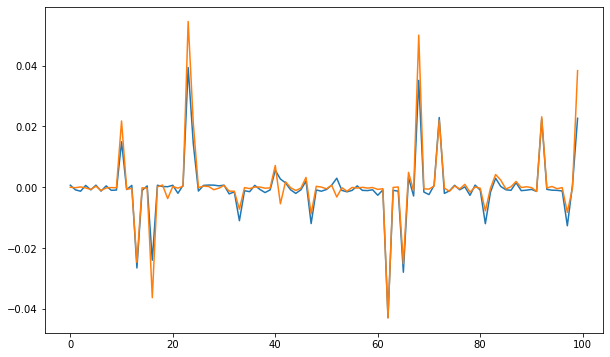

In [74]:
model = tf.keras.models.load_model('FFNN_noise %f.h5'%(sigma))
trainPredict = model.predict(x_train_G)
error=np.abs(trainPredict[:,0]*0.001-y_train_G*0.001)
MAE1=np.mean(error)  # the mean absolute error
MAE2=np.mean(np.abs(y_train_G))
plt.figure(figsize=(10, 6))
plt.plot(trainPredict[3900:4000]*0.01)
plt.plot(y_train_G[3900:4000]*0.01)
print(MAE1)
print(MAE2)

## 3.Simulating angle sequence with the initial condition only for noisy data

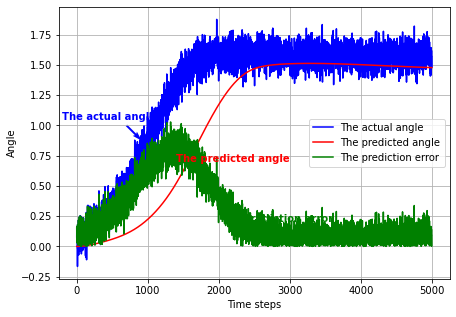

In [76]:
# Simulating angle sequence with the initial condition for noisy data            
a_test=50
random_length=5000

x1=np.zeros((random_length)).squeeze() # "real" angle
x2=np.zeros((random_length)).squeeze() # "real" angular
x1_test=np.zeros((1, random_length)).squeeze()  # predicted angle with feedback
x2_test=np.zeros((1,random_length)).squeeze()  # predicted angular velocity with feedback
#Initialize the angle and angular velocity
x1[0]=0.1
x1[1]=0.1001
x2[0]=(x1[1]-x1[0])/di 

x1_test_f[0]=x1[0]
x2_test_f[0]=x2[0]

#representive torque parameters
c1=4.2816e-7
c2=1.568
c3=5.7534

#get the "real" angle sequence
for t in range(random_length-1):
    hinput=a_test*1000/(4*np.pi)
    x1[t+1]=x1[t]+di*x2[t]
    x2[t+1]=x2[t]+di*(-c3*x2[t]+c2*np.cos(x1[t])+c1*hinput*abs(hinput)*np.sin(2*x1[t]))

x1 = G_noise(x1)

dx1 = np.zeros((1, random_length)).squeeze()
model1 = tf.keras.models.load_model('FFNN_noise %f.h5'%(sigma))
for t in range(random_length-1):
    dx1[t]=model1.predict([[x1_test[t],x2_test[t],a_test]])
    noise=np.random.normal(0,sigma)
    dx1[t]=dx1[t]+noise
    x1_test[t+1]=x1_test[t]+x2_test[t]*di
    x2_test[t+1]=x2_test[t]+dx1[t]*di

error = np.abs(x1[1:random_length:1] - x1_test[1:random_length:1])
MAE = np.mean(error)
#MAE_final[s]
 #plot figure
plt.figure(figsize=(7,5))
plt.plot(x1,"b",label="The actual angle ")
plt.plot(x1_test,"r", label="The predicted angle" )
plt.plot(error[:5000],"g",label="The prediction error")
plt.legend()
plt.text(-200,1.05,"The actual angle",weight="bold",color="blue")
plt.quiver(700, 1, 1, -1, color='b', width=0.005)
plt.text(1400,0.7,"The predicted angle",weight="bold",color="r")
plt.quiver(1400, 0.75, -1, 1, color='r', width=0.005)
plt.text(2000,0.2,"The prediction error",weight="bold",color="g")
plt.quiver(2500, 0.13, 1, -1, color='g', width=0.005)
plt.grid(True)
plt.xlabel("Time steps")
plt.ylabel("Angle")

plt.savefig("Angle_noise%f.png"%(sigma))
#print(seeds)
#print(MAE_final)

# Combine all together.  
## Try ten different kinds of noises by setting the standard deviation from $0.01$ to $0.1$ with the interval of $0.01$. 
## For each kind of noise, we run the simulation ten times by setting different initial seeds from 5 to 50 with interval 5.


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from Euler_approximation import euler
import scipy
from scipy import signal
from scipy.signal import lfilter

MAE_final = np.ones((1, 10)).squeeze()
seeds= np.ones((1, 10)).squeeze()
for s in range(10):
    ## Generate Gussian noise
    sigma=0.01*(s+1) # change standard deviation: Range 0.01-0.1
    def G_noise(x):
        mu=0  # noise mean
        noise=np.random.normal(mu,sigma, x.shape)
        x=x+noise
        return x

    [a1,a2,a3,a4]=[20,40,60,80]
    [phi1_a1,phi2_a1]=euler(a1)
    [phi1_a2,phi2_a2]=euler(a2)
    [phi1_a3,phi2_a3]=euler(a3)
    [phi1_a4,phi2_a4]=euler(a4)

    split_time =8000
    di=0.001


    #Filter parameters
    filter_window=int(1201+sigma*10000)  #Smooth filter window changes as standard deviation(sigma)
    filter_poly=5

    #Filte noisy angle with Savitzky–Golay
    phi1_a1=signal.savgol_filter(G_noise(phi1_a1), filter_window, filter_poly)
    phi1_a2=signal.savgol_filter(G_noise(phi1_a2), filter_window, filter_poly)
    phi1_a3=signal.savgol_filter(G_noise(phi1_a3), filter_window, filter_poly)
    phi1_a4=signal.savgol_filter(G_noise(phi1_a4), filter_window, filter_poly)
     #Get the angle sequence
    phi1_all=np.concatenate((phi1_a1[:split_time],phi1_a2[:split_time],phi1_a3[:split_time],phi1_a4[:split_time]),axis=0)

    #Get the angular velocity
    phi2_a1[:split_time]=(phi1_a1[1:split_time+1]-phi1_a1[:split_time])/di
    phi2_a2[:split_time]=(phi1_a2[1:split_time+1]-phi1_a2[:split_time])/di
    phi2_a3[:split_time]=(phi1_a3[1:split_time+1]-phi1_a3[:split_time])/di
    phi2_a4[:split_time]=(phi1_a4[1:split_time+1]-phi1_a4[:split_time])/di


    #Filte noisy angular velocity with Savitzky–Golay
    phi2_a1=signal.savgol_filter(phi2_a1,filter_window,  filter_poly)
    phi2_a2=signal.savgol_filter(phi2_a2, filter_window, filter_poly)
    phi2_a3=signal.savgol_filter(phi2_a3, filter_window, filter_poly)
    phi2_a4=signal.savgol_filter(phi2_a4, filter_window, filter_poly)

    #Get the angular velocity sequence
    phi2_all=np.concatenate((phi2_a1[:split_time],phi2_a2[:split_time],phi2_a3[:split_time],phi2_a4[:split_time]),axis=0)

    #Filte angular acceleration with Savitzky–Golay
    phi2_diff_a1=signal.savgol_filter(phi2_a1[1:split_time+1]-phi2_a1[:split_time],filter_window, filter_poly)
    phi2_diff_a2=signal.savgol_filter(phi2_a2[1:split_time+1]-phi2_a2[:split_time], filter_window, filter_poly)
    phi2_diff_a3=signal.savgol_filter(phi2_a3[1:split_time+1]-phi2_a3[:split_time], filter_window, filter_poly)
    phi2_diff_a4=signal.savgol_filter(phi2_a4[1:split_time+1]-phi2_a4[:split_time], filter_window, filter_poly)

    #Get the angular acceleration sequence
    phi2_diff_all=np.concatenate((phi2_diff_a1,phi2_diff_a2,phi2_diff_a3,phi2_diff_a4),axis=0)
    phi2_diff_all=phi2_diff_all/di

    # Get the control input sequence 
    input_a1=a1*np.ones(split_time)
    input_a2=a2*np.ones(split_time)
    input_a3=a3*np.ones(split_time)
    input_a4=a4*np.ones(split_time)
    input=np.concatenate((input_a1,input_a2,input_a3,input_a4),axis=0)

    # Stack all data together
    series_input=np.stack((phi1_all,phi2_all,input,phi2_diff_all),axis=1)
    series_input=series_input.reshape(4*split_time,4)
    series_input=tf.random.shuffle(series_input)
    #Shuffle data for avioding overfitting
    x_train_G=series_input[:,0:3]
    y_train_G=series_input[:,3]
    
   
    MAE_G = np.ones((1, 10)).squeeze()
    for seed in range(10):  #Try different seed and the get the best one.     
        tf.random.set_seed(5+seed*5)
        print("sigma=%f"%(sigma))
        print("seed=%d"%(5+seed*5))
        model = tf.keras.Sequential([tf.keras.layers.Dense(60,kernel_initializer='glorot_uniform',activation="elu"),
                                     tf.keras.layers.Dense(30,kernel_initializer='glorot_uniform', activation="elu"),
                                     tf.keras.layers.Dense(1)])

        optimizer = tf.keras.optimizers.SGD(lr=5e-4, momentum=0.9)

        model.compile(loss=tf.keras.losses.Huber(),
                      optimizer=optimizer,
                      metrics=["mae"])

        class CustomCallbacks(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs={}):
              if(logs.get('mae')<0.1):
                print("\n 99% acc reached")
                self.model.stop_training = True

        history= model.fit(x_train_G, y_train_G, epochs=800, callbacks=[CustomCallbacks()])
        trainPredict = model.predict(x_train_G)
        error=np.abs(trainPredict[:,0]*0.001-y_train_G*0.001)
        MAE_G[seed]=np.mean(error)  # the mean absolute error
        
        if MAE_G[seed]==np.min(MAE_G):
            model.save('FFNN_noise %f.h5'%(sigma)) #save the best model by using best seed
            m=seed
            print("best seed=%d"%(5+m*5))
    seeds[s]=5+m*5 
    
# Simulating angle sequence with the initial condition for noisy data            
    a_test=50
    random_length=5000

    x1=np.zeros((random_length)).squeeze() # "real" angle
    x2=np.zeros((random_length)).squeeze() # "real" angular
    x1_test=np.zeros((1, random_length)).squeeze()  # predicted angle with feedback
    x2_test=np.zeros((1,random_length)).squeeze()  # predicted angular velocity with feedback
    #Initialize the angle and angular velocity
    x1[0]=0.1
    x1[1]=0.1001
    x2[0]=(x1[1]-x1[0])/di 

    x1_test_f[0]=x1[0]
    x2_test_f[0]=x2[0]

    #representive torque parameters
    c1=4.2816e-7
    c2=1.568
    c3=5.7534

    #get the "real" angle sequence
    for t in range(random_length-1):
        hinput=a_test*1000/(4*np.pi)
        x1[t+1]=x1[t]+di*x2[t]
        x2[t+1]=x2[t]+di*(-c3*x2[t]+c2*np.cos(x1[t])+c1*hinput*abs(hinput)*np.sin(2*x1[t]))

    x1 = G_noise(x1)

    dx1 = np.zeros((1, random_length)).squeeze()
    model1 = tf.keras.models.load_model('FFNN_noise %f.h5'%(sigma))
    for t in range(random_length-1):
        dx1[t]=model1.predict([[x1_test[t],x2_test[t],a_test]])
        noise=np.random.normal(0,sigma)
        dx1[t]=dx1[t]+noise
        x1_test[t+1]=x1_test[t]+x2_test[t]*di
        x2_test[t+1]=x2_test[t]+dx1[t]*di

    error = np.abs(x1[1:random_length:1] - x1_test[1:random_length:1])
    MAE_final[s] = np.mean(error)
    MAE_final[s]
     #plot figure
    plt.figure(figsize=(7,5))
    plt.plot(x1,"b",label="The actual angle ")
    plt.plot(x1_test,"r", label="The predicted angle" )
    plt.plot(error[:5000],"g",label="The prediction error")
    plt.legend()
    plt.text(-200,1.05,"The actual angle",weight="bold",color="blue")
    plt.quiver(700, 1, 1, -1, color='b', width=0.005)
    plt.text(1400,0.7,"The predicted angle",weight="bold",color="r")
    plt.quiver(1400, 0.75, -1, 1, color='r', width=0.005)
    plt.text(2000,0.2,"The prediction error",weight="bold",color="g")
    plt.quiver(2500, 0.13, 1, -1, color='g', width=0.005)
    plt.grid(True)
    plt.xlabel("Time steps")
    plt.ylabel("Angle")

    plt.savefig("Angle_noise%f.png"%(sigma))
print(seeds)
print(MAE_final)


  According the above result, the best seeds and MAE for different noise data are
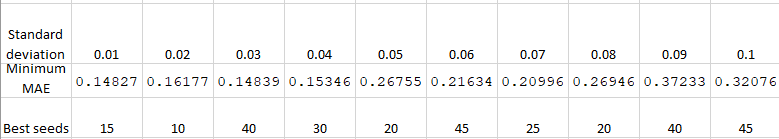
  